Epoch 1/5, Batch 0/938, Loss: 2.2941
Epoch 1/5, Batch 100/938, Loss: 0.6160
Epoch 1/5, Batch 200/938, Loss: 0.3066
Epoch 1/5, Batch 300/938, Loss: 0.2684
Epoch 1/5, Batch 400/938, Loss: 0.1441
Epoch 1/5, Batch 500/938, Loss: 0.1889
Epoch 1/5, Batch 600/938, Loss: 0.0763
Epoch 1/5, Batch 700/938, Loss: 0.2388
Epoch 1/5, Batch 800/938, Loss: 0.1326
Epoch 1/5, Batch 900/938, Loss: 0.0764
Epoch 2/5, Batch 0/938, Loss: 0.1024
Epoch 2/5, Batch 100/938, Loss: 0.1955
Epoch 2/5, Batch 200/938, Loss: 0.1910
Epoch 2/5, Batch 300/938, Loss: 0.0927
Epoch 2/5, Batch 400/938, Loss: 0.2321
Epoch 2/5, Batch 500/938, Loss: 0.1198
Epoch 2/5, Batch 600/938, Loss: 0.1555
Epoch 2/5, Batch 700/938, Loss: 0.1543
Epoch 2/5, Batch 800/938, Loss: 0.1642
Epoch 2/5, Batch 900/938, Loss: 0.1805
Epoch 3/5, Batch 0/938, Loss: 0.0955
Epoch 3/5, Batch 100/938, Loss: 0.0435
Epoch 3/5, Batch 200/938, Loss: 0.1763
Epoch 3/5, Batch 300/938, Loss: 0.0674
Epoch 3/5, Batch 400/938, Loss: 0.1784
Epoch 3/5, Batch 500/938, Loss:

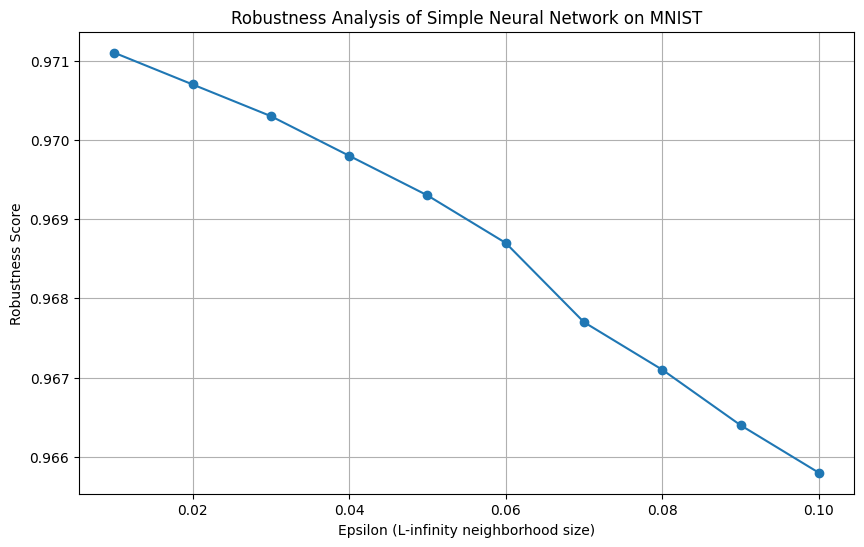

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(784, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')

def interval_analysis(model, x, epsilon):
    model.eval()
    x = x.view(-1, 784)

    lower_bound = x - epsilon
    upper_bound = x + epsilon

    for layer in [model.fc1, model.fc2, model.fc3]:
        weights = layer.weight
        biases = layer.bias

        lower_output = torch.matmul(lower_bound, weights.t()) + biases
        upper_output = torch.matmul(upper_bound, weights.t()) + biases

        lower_bound = torch.max(lower_output, torch.zeros_like(lower_output))
        upper_bound = torch.max(upper_output, torch.zeros_like(upper_output))

    return lower_bound, upper_bound

def measure_robustness(model, test_loader, epsilons):
    model.eval()
    robustness_scores = []

    for epsilon in epsilons:
        correct = 0
        total = 0

        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            lower_bound, upper_bound = interval_analysis(model, data, epsilon)

            predicted_lower = lower_bound.argmax(dim=1)
            predicted_upper = upper_bound.argmax(dim=1)

            correct += ((predicted_lower == target) & (predicted_upper == target)).sum().item()
            total += target.size(0)

        robustness_score = correct / total
        robustness_scores.append(robustness_score)
        print(f"Epsilon: {epsilon:.3f}, Robustness Score: {robustness_score:.4f}")

    return robustness_scores

train(model, train_loader, criterion, optimizer)

epsilons = np.linspace(0.01, 0.1, 10)
robustness_scores = measure_robustness(model, test_loader, epsilons)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(epsilons, robustness_scores, marker='o')
plt.xlabel('Epsilon (L-infinity neighborhood size)')
plt.ylabel('Robustness Score')
plt.title('Robustness Analysis of Simple Neural Network on MNIST')
plt.grid(True)
plt.show()